In [1]:
import warnings
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
from os import listdir
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve
import nltk

from nltk.tokenize import word_tokenize

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout 
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

# os.environ["TF_KERAS"]='1'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

import cv2
from sklearn.manifold import TSNE
from tqdm import tqdm
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
import gensim
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.colors as mcolors
from collections import Counter
from matplotlib.ticker import FuncFormatter
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

Num GPUs Available:  0


In [2]:
!python --version

# Version des bibliothèques utilisées
print('\n'.join(f'{m.__name__} - {m.__version__}' 
                for m in globals().values() 
                if getattr(m, '__version__', None)))



Python 3.11.5
pandas - 2.0.3
numpy - 1.24.3
seaborn - 0.12.2
nltk - 3.8.1
tensorflow - 2.12.0
cv2 - 4.8.1
gensim - 4.3.0


In [3]:
warnings.filterwarnings('ignore')

In [4]:
df =  pd.read_csv('flipkart_com-ecommerce_sample_1050.csv')
df.head(5)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa..."


In [5]:
df.shape

(1050, 15)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

In [7]:
df.sample(5)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
133,5531b9f454e2d75cfe00c3f795e06de5,2015-12-01 12:40:44 +0000,http://www.flipkart.com/rockmantra-vintage-min...,Rockmantra Vintage Mini Leafs Ceramic Mug,"[""Kitchen & Dining >> Coffee Mugs >> Rockmantr...",MUGEAGGKFYN8F5TT,499.0,199.0,5531b9f454e2d75cfe00c3f795e06de5.jpg,False,Rockmantra Vintage Mini Leafs Ceramic Mug (5.5...,No rating available,No rating available,NaN,"{""product_specification""=>[{""key""=>""Type"", ""va..."
244,0c4718ae90f2889b7021a99ee1cc106c,2015-12-01 12:40:44 +0000,http://www.flipkart.com/bergner-kadhai-na-l/p/...,Bergner Kadhai NA L,"[""Kitchen & Dining >> Cookware >> Pots & Pans ...",PTPECA2QYCZH8MBV,1499.0,1499.0,0c4718ae90f2889b7021a99ee1cc106c.jpg,False,"Bergner Kadhai NA L (Aluminium, Non-stick)\r\n...",No rating available,No rating available,Bergner,"{""product_specification""=>[{""key""=>""Pan Type"",..."
805,0b793c1727ef52285a25dedf8b86626b,2015-12-12 11:46:53 +0000,http://www.flipkart.com/oxyglow-bearberry-face...,Oxyglow Bearberry Face Wash & Fruit Massage Cr...,"[""Beauty and Personal Care >> Combos and Kits ...",CBKE9WKTKZDY7GGH,490.0,407.0,0b793c1727ef52285a25dedf8b86626b.jpg,False,Buy Oxyglow Bearberry Face Wash & Fruit Massag...,No rating available,No rating available,NaN,"{""product_specification""=>[{""key""=>""Organic Ty..."
519,dbcaa93cc0542079e9c88db51ec23676,2016-01-07 05:50:25 +0000,http://www.flipkart.com/maxima-21131cpgi-mac-a...,Maxima 21131CPGI Mac Attivo Analog Watch - Fo...,"[""Watches >> Wrist Watches >> Maxima Wrist Wat...",WATE4S5RZY2TJUHP,695.0,695.0,dbcaa93cc0542079e9c88db51ec23676.jpg,True,Maxima 21131CPGI Mac Attivo Analog Watch - Fo...,No rating available,No rating available,NaN,"{""product_specification""=>[{""key""=>""Other Dime..."
597,30ab693b54e99a469a1152b5db14aa40,2016-03-21 12:00:58 +0000,http://www.flipkart.com/little-feetz-baby-girl...,LITTLE FEETZ Baby Girl's Solid Top & Skirt Set,"[""Baby Care >> Infant Wear >> Baby Girls' Clot...",NSTEHYA7NGZJ6Z5B,615.0,489.0,30ab693b54e99a469a1152b5db14aa40.jpg,False,Key Features of LITTLE FEETZ Baby Girl's Solid...,No rating available,No rating available,LITTLE FEETZ,"{""product_specification""=>[{""key""=>""Pattern"", ..."


In [8]:
df.dtypes.value_counts()

object     12
float64     2
bool        1
Name: count, dtype: int64

In [9]:
df.isna().sum()

uniq_id                      0
crawl_timestamp              0
product_url                  0
product_name                 0
product_category_tree        0
pid                          0
retail_price                 1
discounted_price             1
image                        0
is_FK_Advantage_product      0
description                  0
product_rating               0
overall_rating               0
brand                      338
product_specifications       1
dtype: int64

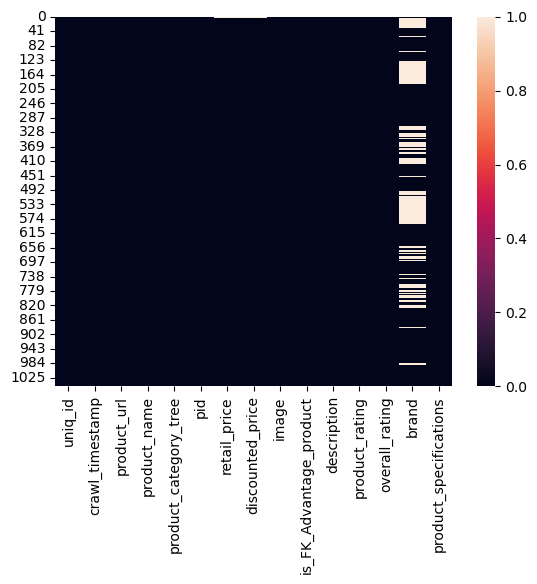

In [10]:
sns.heatmap(df.isnull());

In [11]:
df.duplicated().sum()

0

In [12]:
df.duplicated(subset='description').sum()

0

### Inspection des données 

In [13]:
df.describe(include=np.number)

,retail_price,discounted_price
count,1049.000000,1049.000000
mean,2186.197331,1584.527169
std,7639.229411,7475.099680
min,35.000000,35.000000
25%,555.000000,340.000000
50%,999.000000,600.000000
75%,1999.000000,1199.000000
max,201000.000000,201000.000000


In [14]:
df.describe(include=object)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,image,description,product_rating,overall_rating,brand,product_specifications
count,1050,1050,1050,1050,1050,1050,1050,1050,1050,1050,712,1049
unique,1050,149,1050,1050,642,1050,1050,1050,27,27,490,984
top,55b85ea15a1536d46b7190ad6fff8ce7,2015-12-01 12:40:44 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Bed Linen >> Blankets, Qu...",CRNEG7BKMFFYHQ8Z,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,PRINT SHAPES,"{""product_specification""=>[{""key""=>""Type"", ""va..."
freq,1,150,1,1,56,1,1,1,889,889,11,22


### Nettoyage des données

In [15]:
df_net = df.dtypes
df_net

uniq_id                     object
crawl_timestamp             object
product_url                 object
product_name                object
product_category_tree       object
pid                         object
retail_price               float64
discounted_price           float64
image                       object
is_FK_Advantage_product       bool
description                 object
product_rating              object
overall_rating              object
brand                       object
product_specifications      object
dtype: object

In [16]:
cols = ['uniq_id','description']
df_t = df[cols]
df_t.sample(10)

,uniq_id,description
777,46c7cb82a768ad8811db821d8649f6e0,RRTC RRTC1105SM00 Basic Analog Watch - For Wo...
409,c6cd71c28144224b080cdec222bc4833,Flipkart.com: Buy Adidas Ice Dive and Adidas V...
386,59d964c38c787f829c6cfa5629e4df90,Flipkart.com: Buy French Factor Man of the Yea...
175,22ea3b69860bc9a5e0c69b87db2dcdab,Buy Prithish I'm A Mom. What'S Your Superpower...
240,7e4c1d31e279a700c6b8e66d820e8601,Buy Kosher Kadhai 5 L for Rs.592 online. Koshe...
478,a0133654f3911e47f021da4e49d42926,"Cotonex Yellow, Green Cotton Kitchen Linen Set..."
588,156bcd3aba1838a2b6bad856654db964,Timewel N1536(GW)_1 Analog Watch - For Men - ...
475,1c0fdd598671f6f4e10b21435d766cf3,Key Features of Allin Exporters Cumin Seed Oil...
1017,4748b7ea0e01cffa561f1a7a7a432813,Key Features of Aroma Comfort Polyester Cream ...
517,86b358a265312c139e5714e663daff05,Sonata 87001SL01 Analog Watch - For Women - B...


### Valeurs manquantes

In [17]:
df_t.isna().mean()

uniq_id        0.0
description    0.0
dtype: float64

In [18]:
df_t.duplicated(subset="description").sum()

0

## Exploration des données
#### longueur

In [19]:
df_t.description.apply(lambda i : len(i))

0       1420
1        444
2       1258
3        858
4       1197
        ... 
1045    2432
1046    1660
1047     262
1048     210
1049     187
Name: description, Length: 1050, dtype: int64

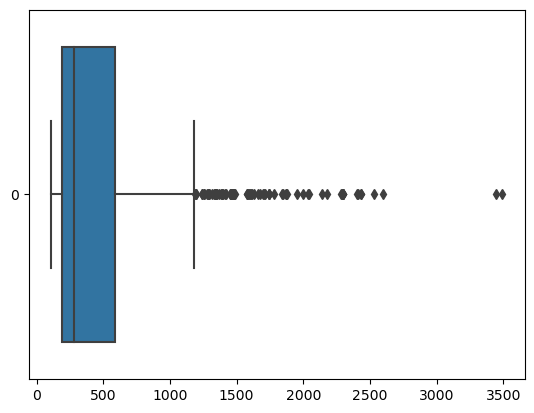

In [20]:
tmp = df_t.description.str.len()
sns.boxplot(tmp, orient='h');

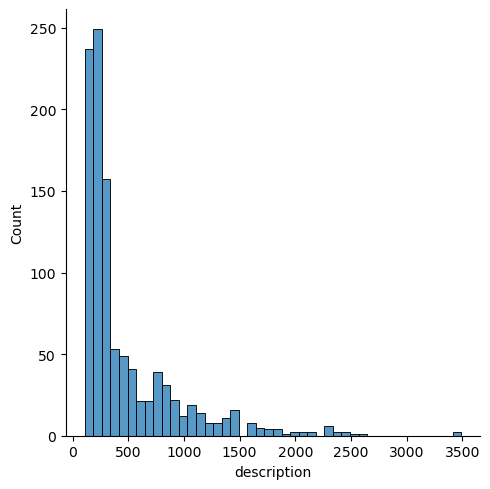

In [21]:
sns.displot(tmp);

In [22]:
df_long = df_t["_lon_desc"] = tmp
df_long.head(10)

0    1420
1     444
2    1258
3     858
4    1197
5     275
6     268
7     817
8     410
9     430
Name: description, dtype: int64

### Exploration du corpus et des documents

In [23]:
df_t.head(10)

,uniq_id,description,_lon_desc
0,55b85ea15a1536d46b7190ad6fff8ce7,Key Features of Elegance Polyester Multicolor ...,1420
1,7b72c92c2f6c40268628ec5f14c6d590,Specifications of Sathiyas Cotton Bath Towel (...,444
2,64d5d4a258243731dc7bbb1eef49ad74,Key Features of Eurospa Cotton Terry Face Towe...,1258
3,d4684dcdc759dd9cdf41504698d737d8,Key Features of SANTOSH ROYAL FASHION Cotton P...,858
4,6325b6870c54cd47be6ebfbffa620ec7,Key Features of Jaipur Print Cotton Floral Kin...,1197
5,893aa5ed55f7cff2eccea7758d7a86bd,Maserati Time R8851116001 Analog Watch - For ...,275
6,f355cc1ccb08bd0d283ed979b7ee7515,"Camerii WM64 Elegance Analog Watch - For Men,...",268
7,dd0e3470a7e6ed76fd69c2da27721041,T STAR UFT-TSW-005-BK-BR Analog Watch - For B...,817
8,41384da51732c0b4df3de8f395714fbb,"Alfajr WY16B Youth Digital Watch - For Men, B...",410
9,710ed5f2393a4b9e8823aa0029f71f93,TAG Heuer CAU1116.BA0858 Formula 1 Analog Watc...,430


In [24]:
df_samp = df_t.sample(10)
df_samp

,uniq_id,description,_lon_desc
839,fc9a650d545a50c72556bed0df59efa1,Buy Himtek light led 1 USB Led Light for Rs.11...,195
23,4788f5466992da09024b8ffcc8a5cba4,Skmei DG0939-Red Sports Digital Watch - For M...,351
485,44b963eb856b4831dfdd21b666593c95,Lapguard Lenovo IdeaPad V470 6 Cell Laptop Bat...,1674
252,6bc04b3ec1f8d4da2a00f8662f4fbed3,Buy Metallino Kadhai NA L for Rs.721 online. M...,173
105,789cf5578f48577a44586fca3adc35d0,Buy Shop Rajasthan Abstract Single Dohar Multi...,135
253,fb733e04ff2d72c59d8513eb574e81a2,Buy Metallino Hard Anodised WGlass Lid Kadhai ...,226
203,5b378b0925d5409b5d84ceb416fc2afc,Buy Purpledip Showpiece - 12 cm for Rs.638 o...,189
522,c7d81193e868b50355412ced7a67f8f3,Maxima 24742LMGY Gold Analog Watch - For Men ...,302
473,ba9f3a5ab1517a644322d856a7d25946,Key Features of Allin Exporters Fennel Oil (Co...,1017
277,113783ce1db999778b5a4bd374e61209,Key Features of palito PLO 169 Analog Watch -...,338


In [25]:
for idx, ser in df_samp.iterrows():
    id_prod = f": {ser['uniq_id']}\n"
    print( id_prod + ser["description"]+ "..." +"\n\n")

: fc9a650d545a50c72556bed0df59efa1
Buy Himtek light led 1 USB Led Light for Rs.119 online. Himtek light led 1 USB Led Light at best prices with FREE shipping & cash on delivery. Only Genuine Products. 30 Day Replacement Guarantee....


: 4788f5466992da09024b8ffcc8a5cba4
Skmei DG0939-Red Sports Digital Watch  - For Men, Boys - Buy Skmei DG0939-Red Sports Digital Watch  - For Men, Boys  DG0939-Red Online at Rs.999 in India Only at Flipkart.com. Digital Chronograph, Alarm Watch, Light Function, Date & Month Display - Great Discounts, Only Genuine Products, 30 Day Replacement Guarantee, Free Shipping. Cash On Delivery!...


: 44b963eb856b4831dfdd21b666593c95
Lapguard Lenovo IdeaPad V470 6 Cell Laptop Battery
                         Price: Rs. 1,799
				
			The product is compatible with the above mentioned model number.This Lapguard replacement battery is made from high grade cells and highest quality parts. This Lapguard brand replacement battery is 100 percent comparable to original bat

In [26]:
import re, nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [27]:
def cleaned_text(text):
    clean = re.sub("\n"," ",text)
    clean=clean.lower()
    clean=re.sub(r"[~.,%/:;?_&+*=!-]"," ",clean)
    clean=re.sub("[^a-z]"," ",clean)
    clean=clean.lstrip()
    clean=re.sub("\s{2,}"," ",clean)
    return clean
df_t["cleaned_description"]=df_t["description"].apply(cleaned_text)

In [28]:
df_t["cleaned_description"] = df_t["cleaned_description"].apply(lambda x: ' '.join([word for word in x.split() if len(word)>3]))

In [29]:
 df_t["cleaned_description"].head(10)

0    features elegance polyester multicolor abstrac...
1    specifications sathiyas cotton bath towel bath...
2    features eurospa cotton terry face towel size ...
3    features santosh royal fashion cotton printed ...
4    features jaipur print cotton floral king sized...
5    maserati time analog watch boys maserati time ...
6    camerii elegance analog watch boys camerii ele...
7    star analog watch boys price whether your work...
8    alfajr youth digital watch boys alfajr youth d...
9    heuer formula analog watch boys heuer formula ...
Name: cleaned_description, dtype: object

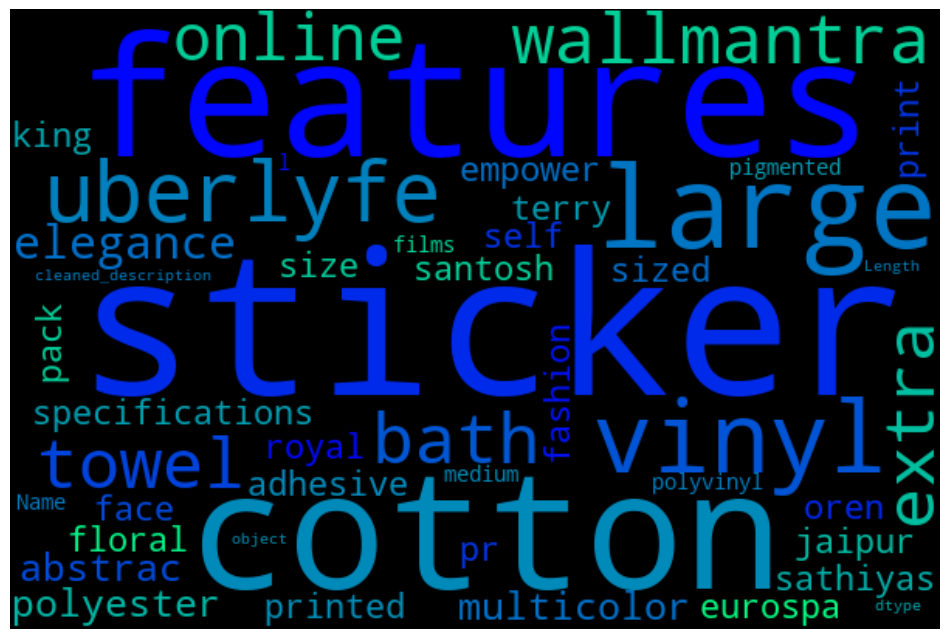

In [30]:
cloud=WordCloud(colormap="winter",width=600,height=400).generate(str(df_t["cleaned_description"]))
fig=plt.figure(figsize=(12,9))
plt.axis("off")
plt.imshow(cloud,interpolation='bilinear');

In [31]:
stop=stopwords.words('english')
stop.append("also")
df_t["stop_removed_description"]=df_t["cleaned_description"].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [32]:
df_t["tokenized"]=df_t["stop_removed_description"].apply(lambda x: nltk.word_tokenize(x))

In [33]:
from nltk.stem import WordNetLemmatizer 

In [34]:
def word_lemmatizer(text):
    lem_text = [WordNetLemmatizer().lemmatize(i,pos='v') for i in text]
    return lem_text
df_t["lemmatized"]=df_t["tokenized"].apply(lambda x: word_lemmatizer(x))
df_t["lemmatize_joined"]=df_t["lemmatized"].apply(lambda x: ' '.join(x))

In [35]:
df_t["lemmatize_joined"].head()

0    feature elegance polyester multicolor abstract...
1    specifications sathiyas cotton bath towel bath...
2    feature eurospa cotton terry face towel size s...
3    feature santosh royal fashion cotton print kin...
4    feature jaipur print cotton floral king size d...
Name: lemmatize_joined, dtype: object

In [36]:
df_t['Number_of_words_for_cleaned'] = df_t['lemmatize_joined'].apply(lambda x:len(str(x).split()))

Text(0.5, 1.0, 'Distribution de fréquence du nombre de mots pour chaque texte extrait après suppression des mots vides et de la lemmatisation')

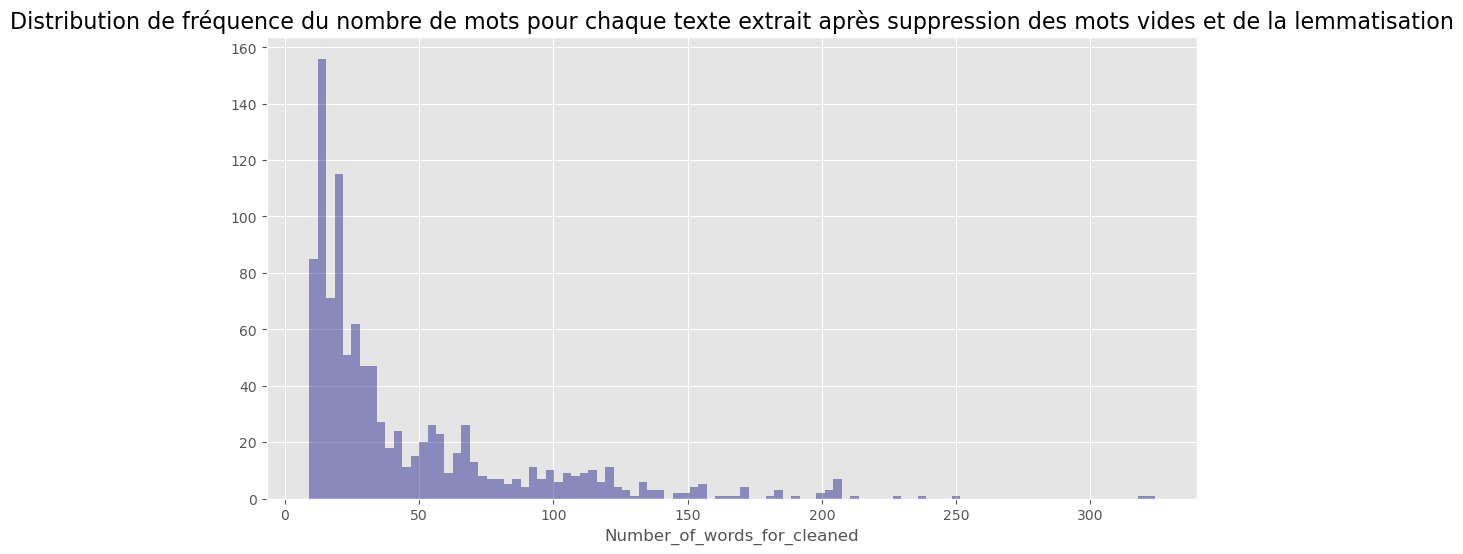

In [37]:
plt.style.use('ggplot')
plt.figure(figsize=(12,6))
sns.distplot(df_t['Number_of_words_for_cleaned'],kde = False, color= "navy", bins = 100)
plt.title("Distribution de fréquence du nombre de mots pour chaque texte extrait après suppression des mots vides et de la lemmatisation", size=16)

In [38]:
df_t.drop(df_t[df_t["Number_of_words_for_cleaned"]>300].index, inplace = True)

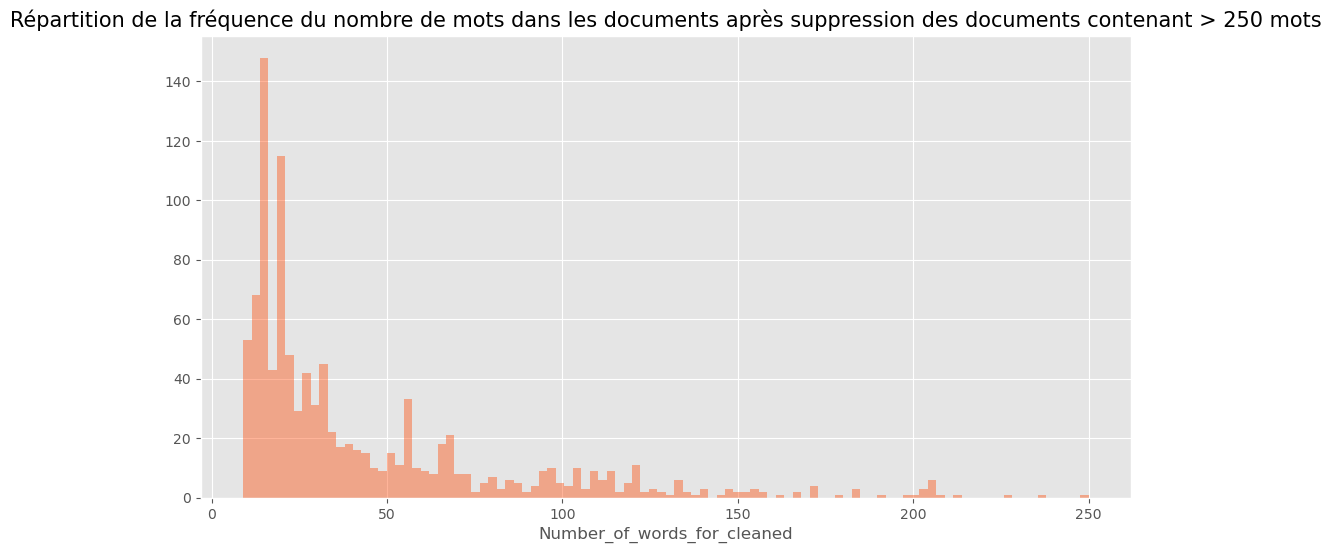

In [39]:
plt.style.use('ggplot')
plt.figure(figsize=(12,6))
sns.distplot(df_t['Number_of_words_for_cleaned'],kde = False, color= "orangered", bins = 100)
plt.title("Répartition de la fréquence du nombre de mots dans les documents après suppression des documents contenant > 250 mots", size=15);

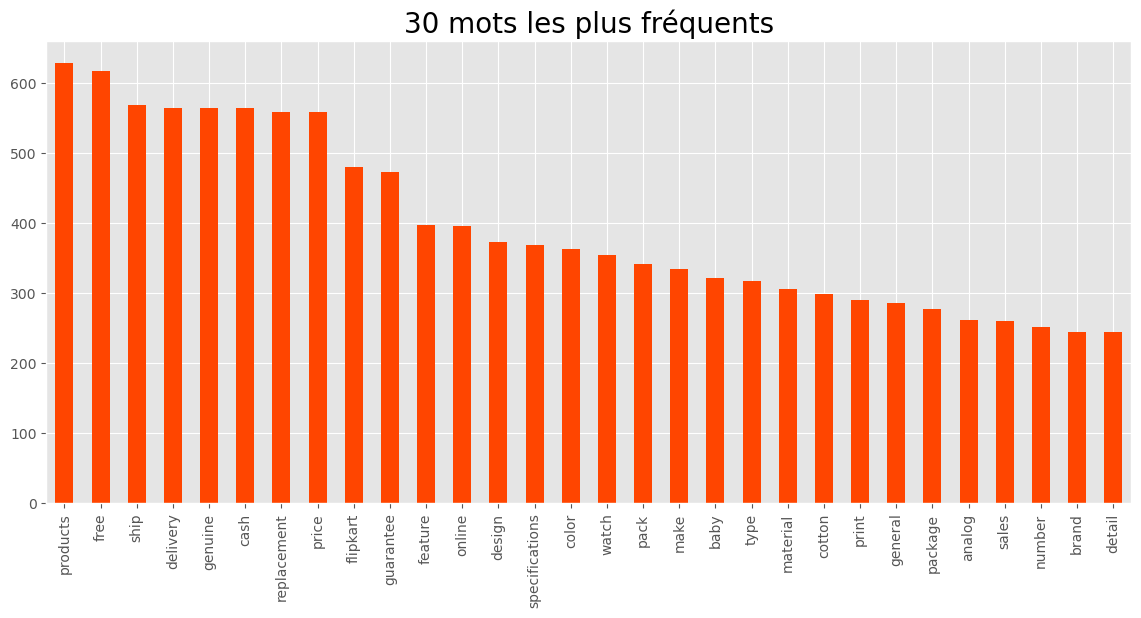

In [40]:
plt.style.use('ggplot')
plt.figure(figsize=(14,6))
freq=pd.Series(" ".join(df_t["lemmatize_joined"]).split()).value_counts()[:30]
freq.plot(kind="bar", color = "orangered")
plt.title("30 mots les plus fréquents",size=20);

In [41]:

from gensim.models import Word2Vec
from sklearn.manifold import TSNE
import matplotlib.colors as mcolors


In [42]:
tokens = df_t["lemmatize_joined"].apply(lambda x: nltk.word_tokenize(x))

In [43]:
w2v_model = Word2Vec(tokens,
                     min_count=300,
                     window=10,                   
                     alpha=0.03, 
                     min_alpha=0.0007,
                     workers = 4,
                     seed = 42)

In [44]:
v1 = w2v_model.wv['products']
print(v1)

[-3.96951139e-02  1.92450266e-02  1.56283572e-01  6.38163462e-02
 -1.95070934e-02  8.28095973e-02 -1.09616742e-01  2.48290654e-02
 -5.93656227e-02 -4.84609641e-02 -3.23601440e-02  1.42102167e-01
  7.19821453e-02  2.15224370e-01  1.04231291e-01  9.99310091e-02
  1.11386832e-02 -2.90624619e-01 -9.55756828e-02  4.03195806e-02
 -2.95527726e-01 -5.92694543e-02  8.49665403e-02  7.17861727e-02
  2.30863750e-01 -1.12636425e-01  7.29455426e-02  3.70183885e-02
 -9.04825032e-02 -2.05813139e-05 -2.29025763e-02 -4.53523397e-02
 -1.38141453e-01  1.72356158e-01  1.17639728e-01 -1.49236396e-02
  1.14800133e-01 -4.64701325e-01 -9.63762030e-02  1.10933945e-01
  1.75763547e-01 -1.36930430e-02  1.51709229e-01 -1.29486263e-01
 -5.38357794e-02 -5.63612767e-02  1.09718256e-01  1.89421222e-01
  3.72829795e-01 -1.12299517e-01  4.24048007e-02 -1.78770095e-01
 -1.79668650e-01  1.35188639e-01  1.21933445e-01 -7.77861178e-02
 -1.61978900e-02  1.58723086e-01  2.67752372e-02  1.01845950e-01
  2.42302299e-01  4.91599

In [45]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=50, n_components=2, init='pca', n_iter=2000, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(15, 13)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

In [ ]:
tsne_plot(w2v_model)